### Find Connected Cameras

In [12]:
import ids_peak.ids_peak as ids_peak

ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
device_manager.Update()
device_descriptors = device_manager.Devices()

print("Found Devices: " + str(len(device_descriptors)))
for device_descriptor in device_descriptors:
    print(device_descriptor.DisplayName())

Found Devices: 1
IDS Imaging Development Systems GmbH U3-368xXCP-NIR (1409f4e8711b U3-368xXCP-NIR-1)


### Open Camera

In [13]:
device = device_descriptors[0].OpenDevice(ids_peak.DeviceAccessType_Control)
print("Opened Device: " + device.DisplayName())
remote_device_nodemap = device.RemoteDevice().NodeMaps()[0]

Opened Device: IDS Imaging Development Systems GmbH U3-368xXCP-NIR (1409f4e8711b U3-368xXCP-NIR-1)


### Set Roi

In [14]:
remote_device_nodemap.FindNode( "OffsetX" ).SetValue(0)
remote_device_nodemap.FindNode( "OffsetY" ).SetValue(0)
remote_device_nodemap.FindNode( "Width" ).SetValue(remote_device_nodemap.FindNode("Width").Maximum())
remote_device_nodemap.FindNode( "Height" ).SetValue(remote_device_nodemap.FindNode("Height").Maximum())

Errors are displayed immediately. No output means no errors.

### Setup Buffer

In [15]:
datastream = device.DataStreams()[0].OpenDataStream()
payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
print(payload_size)
for i in range(datastream.NumBuffersAnnouncedMinRequired()):
    buffer = datastream.AllocAndAnnounceBuffer(payload_size)
    datastream.QueueBuffer(buffer)

5038848


### Change exposure time

In [16]:
remote_device_nodemap.FindNode("ExposureTime").SetValue(20000) # in microseconds

### Start Acquisition

In [17]:
datastream.StartAcquisition()
remote_device_nodemap.FindNode("AcquisitionStart").Execute()
remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

### Capture image

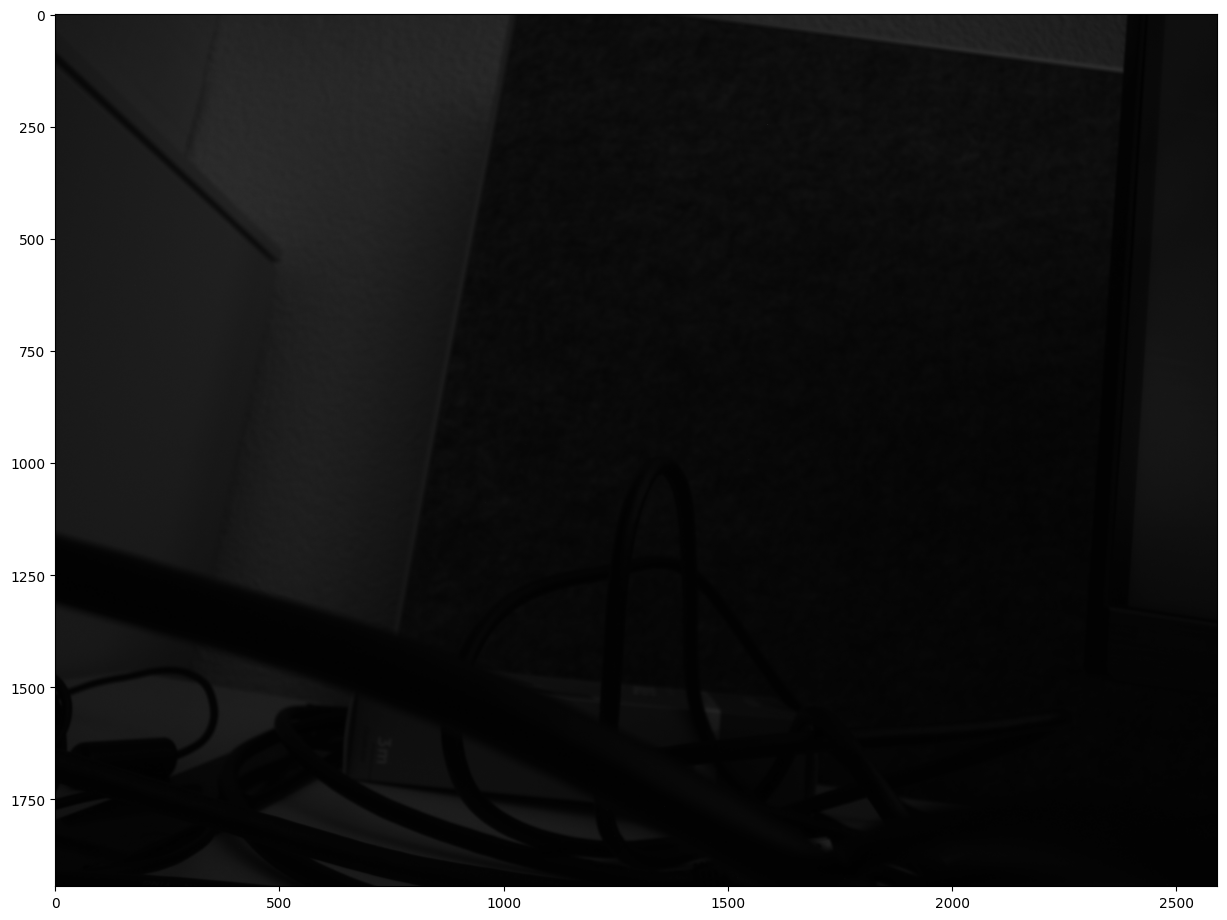

In [18]:
# trigger image
remote_device_nodemap.FindNode("TriggerSoftware").Execute()
buffer = datastream.WaitForFinishedBuffer(1000)

# convert to RGB
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import ids_peak.ids_peak_ipl_extension as ids_ipl_extension
raw_image = ids_ipl_extension.BufferToImage(buffer)
# for Peak version 2.0.1 and lower, use this function instead of the previous line:
#raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_RGB8)
datastream.QueueBuffer(buffer)

import numpy as np
picture = color_image.get_numpy_3D()

# display the image
from matplotlib import pyplot as plt
plt.figure(figsize = (15,15))
plt.imshow(picture)

### Download pre-trained model
Download and initialized the pre-trained YOLOv5 (You-Only-Look-Once) deep learning model 

https://github.com/ultralytics/yolov5#readme

Install instructions: https://github.com/ultralytics/yolov5#requirements

In [19]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\jun/.cache\torch\hub\ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv            

Adding autoShape... 


### Inference / Object Detection
Apply model to ROI image to detect...things

In [20]:
results = model(picture_roi)
results.print()

image 1/1: 1080x1200 5 scissorss
Speed: 0.0ms pre-process, 207.2ms inference, 9.1ms NMS per image at shape (1, 3, 576, 640)


### Draw Inference Results

## Stop Acquisition

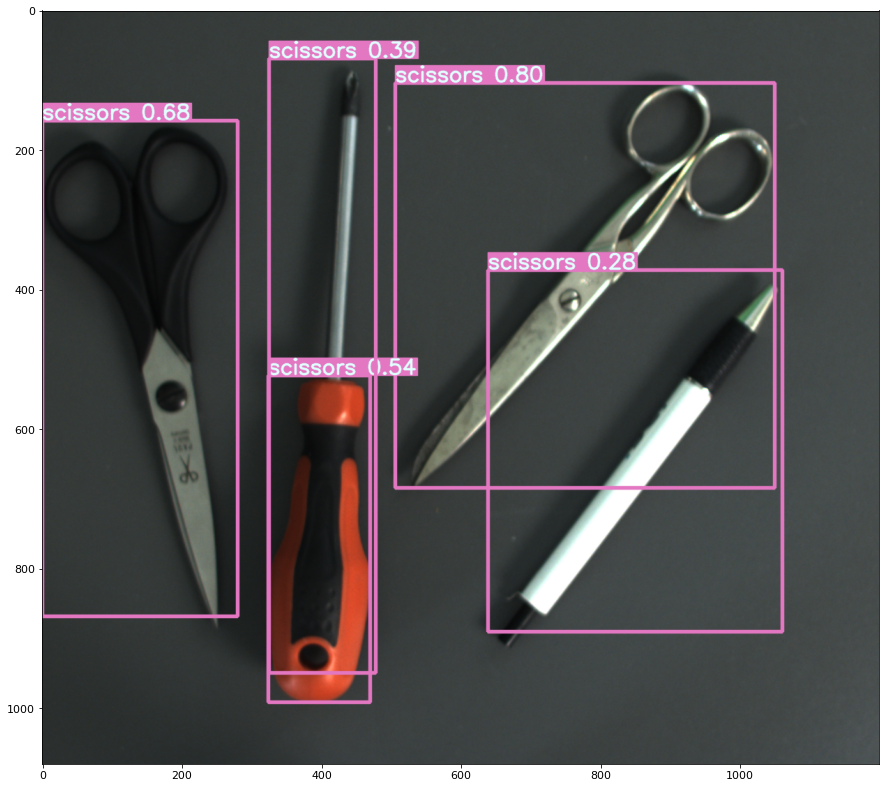

In [21]:
res_img = results.render()[0]
plt.figure(figsize = (15,15))
plt.imshow(res_img)

In [19]:
datastream.StopAcquisition()
datastream.Flush(ids_peak.DataStreamFlushMode_DiscardAll)
for buffer in datastream.AnnouncedBuffers():
    datastream.RevokeBuffer(buffer)
remote_device_nodemap.FindNode("AcquisitionStop").Execute()
remote_device_nodemap.FindNode("AcquisitionStop").WaitUntilDone()

## Restart Acquisition

In [20]:
payload_size = remote_device_nodemap.FindNode("PayloadSize").Value()
print(payload_size)
for i in range(datastream.NumBuffersAnnouncedMinRequired()):
    buffer = datastream.AllocAndAnnounceBuffer(payload_size)
    datastream.QueueBuffer(buffer)
datastream.StartAcquisition()
remote_device_nodemap.FindNode("AcquisitionStart").Execute()
remote_device_nodemap.FindNode("AcquisitionStart").WaitUntilDone()

5038848


## Capture Again

Here I get the error: 
Error-Code: 13 (PEAK_RETURN_CODE_TIMEOUT) | Error-Description: [Function: EventGetData | Error-Code: -1011 (GC_ERR_TIMEOUT) | Error-Text: Wait for event data timed out! Timeout: 1000.

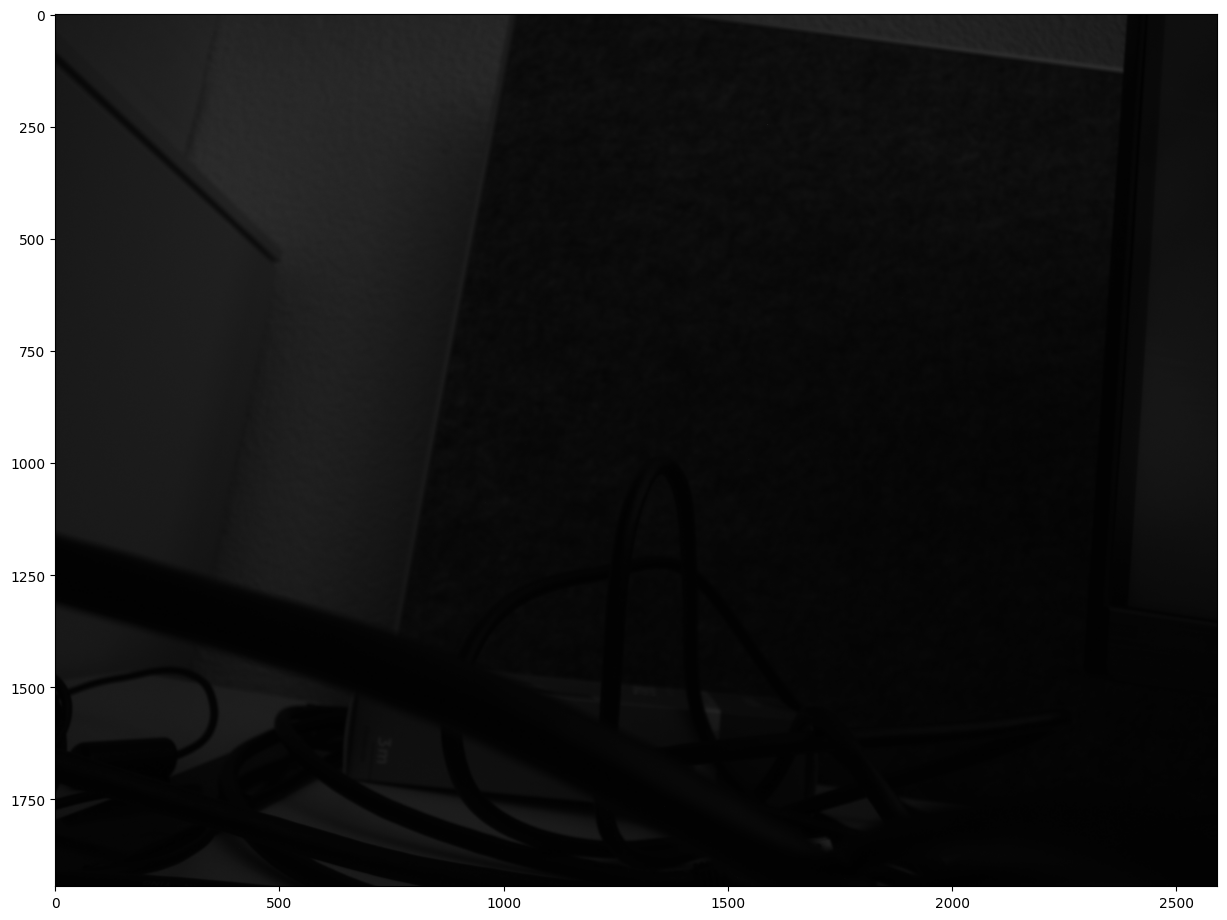

In [21]:
# trigger image
buffer = datastream.WaitForFinishedBuffer(1000)

# convert to RGB
import ids_peak_ipl.ids_peak_ipl as ids_ipl
import ids_peak.ids_peak_ipl_extension as ids_ipl_extension
raw_image = ids_ipl_extension.BufferToImage(buffer)
# for Peak version 2.0.1 and lower, use this function instead of the previous line:
#raw_image = ids_ipl.Image_CreateFromSizeAndBuffer(buffer.PixelFormat(), buffer.BasePtr(), buffer.Size(), buffer.Width(), buffer.Height())
color_image = raw_image.ConvertTo(ids_ipl.PixelFormatName_RGB8)
datastream.QueueBuffer(buffer)

import numpy as np
picture = color_image.get_numpy_3D()

# display the image
from matplotlib import pyplot as plt
plt.figure(figsize = (15,15))
plt.imshow(picture)

In [11]:
ids_peak.Library.Close()